# 1. Importing Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
import random
import torchvision

from typing import List, Dict, Tuple
from torch import nn
from torchvision.transforms import transforms
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from datetime import datetime

from helper_functions import create_dataloaders, set_seeds, display_random_images, plot_loss_curves, save_model, load_model
from engine import train, create_writer
from vision_transformer import ViT, ViTv2
#from torchtune.schedulers import CosineWarmupScheduler

#from torchtune.modules import get_cosine_schedule_with_warmup


NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
AMOUNT_TO_GET = 1.0
SEED = 42
ENABLE = {
    'train_baseline': True,
    'save_baseline':  True,    
}

# Define target data directory
#target_dir_name = f"../data/pizza_steak_sushi_applepie_hamburger_{str(int(AMOUNT_TO_GET*100))}_percent"
target_dir_name = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Create target model directory
model_dir = Path("../models")

# Set seeds
set_seeds(SEED)

ImportError: 
        torchao not installed.
        Please follow the instructions at https://pytorch.org/torchtune/main/install.html#pre-requisites
        to install torchao.
        

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Creating Dataloaders

In [3]:
# Create image size
IMG_SIZE = 224

manual_transforms = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225]) 
])

manual_transforms_norm = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.TrivialAugmentWide(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug_norm = v2.Compose([    
    v2.Resize((256, 256)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),
    v2.TrivialAugmentWide(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()

In [4]:
#print(f"Manually create transforms: {pretrained_vit_weights}")
print(f"Manually create transforms: {manual_transforms_aug_norm}")

Manually create transforms: Compose(
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomCrop(size=(224, 224), pad_if_needed=False, fill=0, padding_mode=constant)
      TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=31)
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)


In [5]:
# Setup the directories
target_dir = Path(target_dir_name)
train_dir = target_dir / "train"
test_dir = target_dir / "test"

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

# Create data loaders
train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm,
    test_transform=manual_transforms_aug_norm,
    batch_size=BATCH_SIZE
)

train_dataloader_vit, test_dataloader_vit, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26ad0e56f50>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot

# 3. Image Visualization

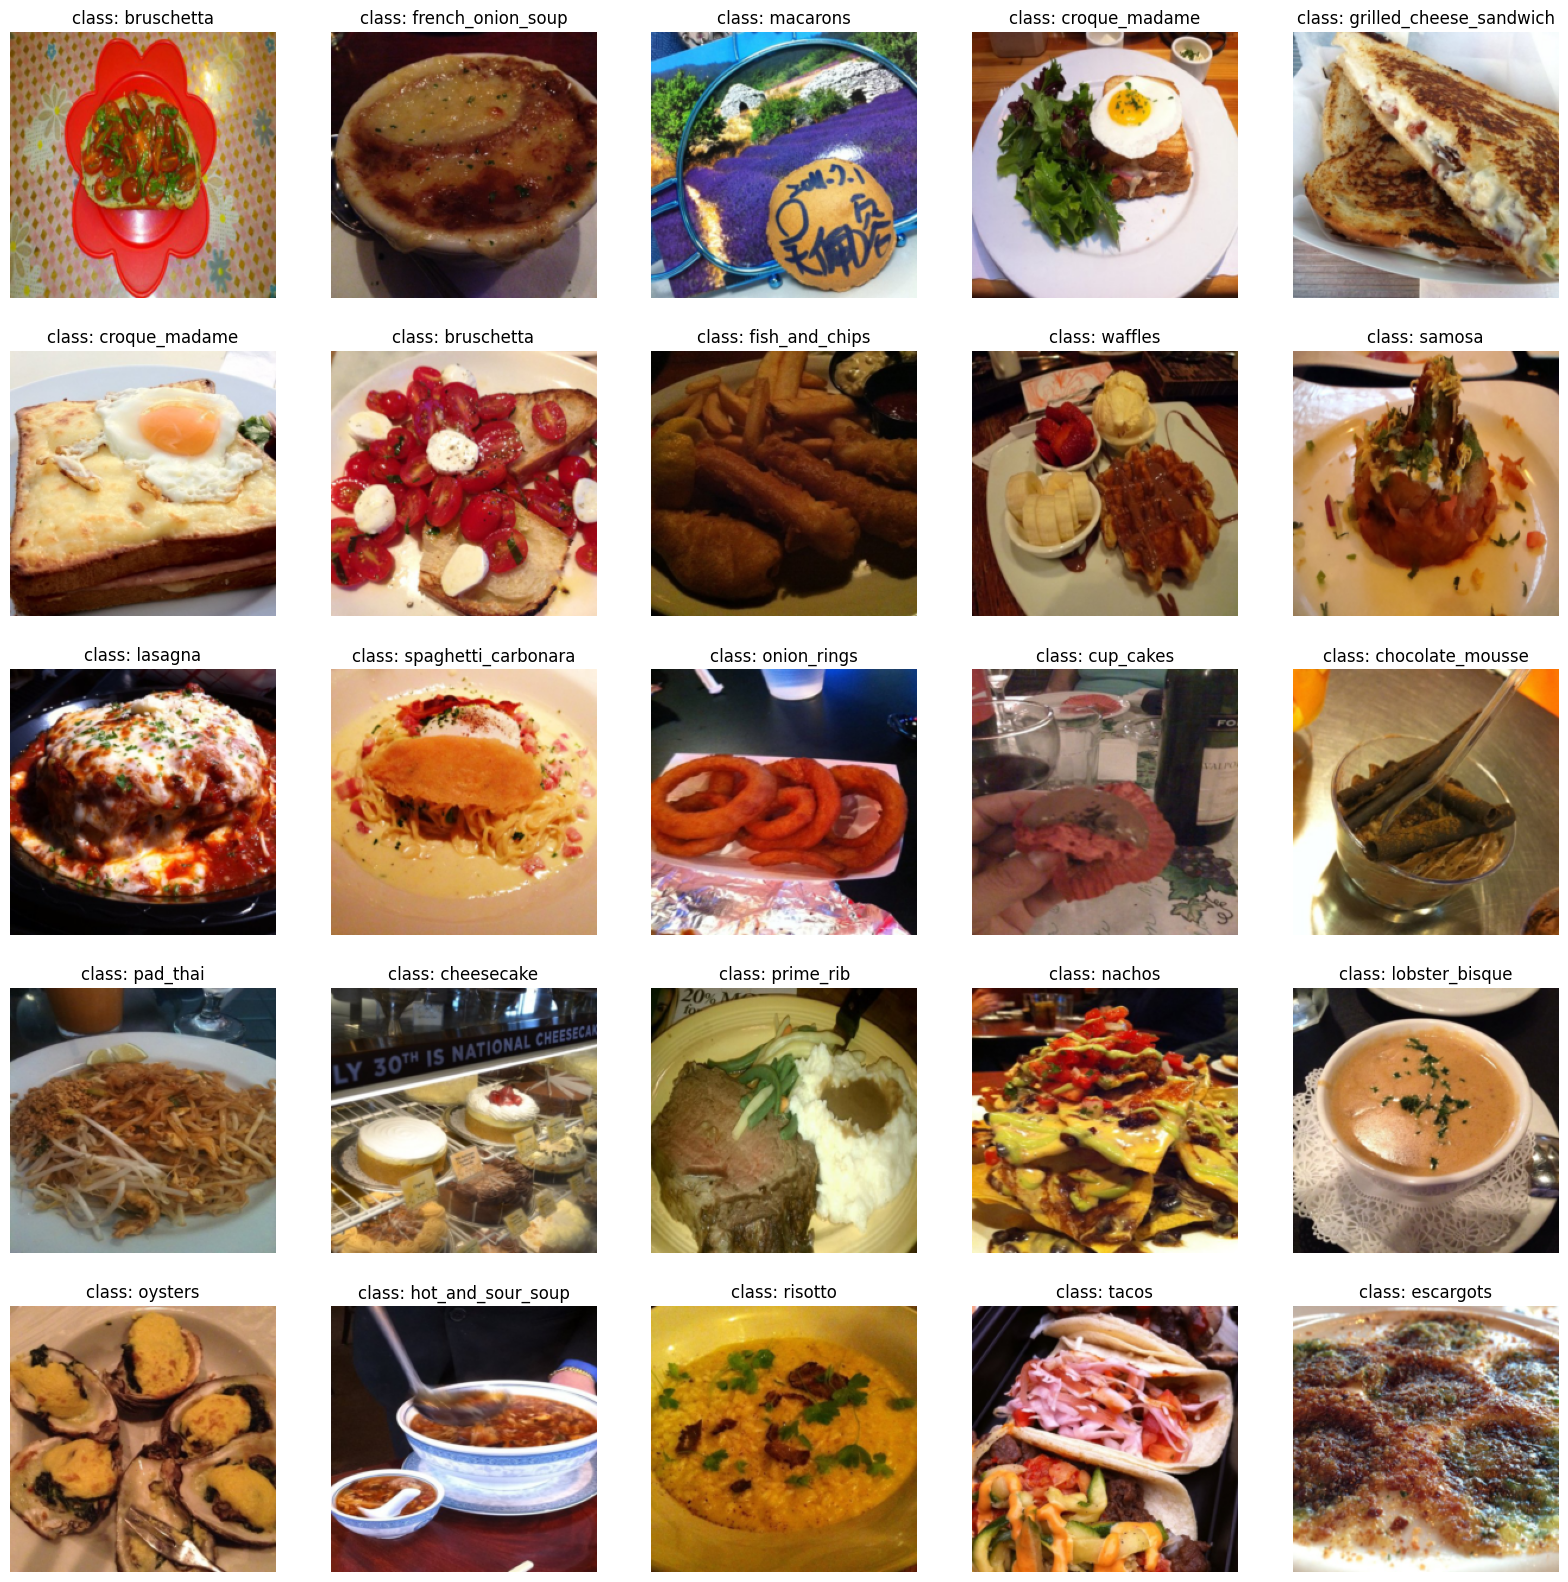

In [6]:
train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=class_names,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 4. Vision Transformer (ViT) - Base

## 4.1 Create and Instantiate the Model

In [7]:
# Create a Vision Transformer Base Model
vitbase = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
).to(device)

# Set the pretrained weights of ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

# And copy them to the instantiated vitbase model, instead of randomly initializing them
#vitbase.copy_weights(pretrained_vit_weights)
#vitbase.to(device)

print("Weights of the pretrained model")
#for name, param in pretrained_vit.named_parameters():
#    print(f"{name}: {param.data.mean()}")

#print("...................")
#print("Weights of the ViTBase model")
#for name, param in vitbase.named_parameters():
#    print(f"{name}: {param.data.mean()}")
    
# And a summary
summary(vitbase,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Weights of the pretrained model


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 101]            --                   True
├─PatchEmbedding (embedder)                                  [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Conv2d (conv_proj)                                    [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
│    └─Dropout (emb_dropout)                                 [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (encoder)                                       [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [8]:
summary(pretrained_vit,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 101]            768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {count_parameters(vitbase)}")
print(f"Total parameters: {count_parameters(pretrained_vit)}")

Total parameters: 85876325
Total parameters: 85876325


## 4.2 Train the Model

In [ ]:
model_type="vitbase"
EPOCHS = 50
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 10000):04d}_{EPOCHS}epochs"
vit_model_name = model_name + ".pth"
vit_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {vit_model_name}")
print(f"Results path: {vit_results_df}")

# Train the model
if ENABLE['train_baseline']:
    # Create an example writer
    vitbase_writer = create_writer(experiment_name="data_100_percent",
                                   model_name=model_name,
                                   extra=f"{EPOCHS}_epochs")
    
    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase.parameters(),
                                lr=LR,
                                betas=(0.9, 0.999),
                                weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)
    #num_warmup_steps = 5 * len(train_dataloader_vit)
    #scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitbase_results = train(model=vitbase,
                            train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None, #scheduler,
                            epochs=EPOCHS,
                            device=device,
                            writer=vitbase_writer)
    
    # Plot loss and accuracy curves
    plot_loss_curves(vitbase_results)

Model name: vitbase_lr0001_50epochs
Model path: vitbase_lr0001_50epochs.pth
Results path: vitbase_lr0001_50epochs.csv
[INFO] Created SummaryWriter, saving to: runs\2024-12-01\data_100_percent\vitbase_lr0001_50epochs\50_epochs...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6044 | train_acc: 0.0199 | test_loss: 4.4003 | test_acc: 0.0404
Epoch: 2 | train_loss: 4.3441 | train_acc: 0.0464 | test_loss: 4.2251 | test_acc: 0.0579
Epoch: 3 | train_loss: 4.2533 | train_acc: 0.0586 | test_loss: 4.1499 | test_acc: 0.0793
Epoch: 4 | train_loss: 4.2136 | train_acc: 0.0690 | test_loss: 4.1721 | test_acc: 0.0792
Epoch: 5 | train_loss: 4.1981 | train_acc: 0.0744 | test_loss: 4.1415 | test_acc: 0.0853
Epoch: 6 | train_loss: 4.1664 | train_acc: 0.0775 | test_loss: 4.1025 | test_acc: 0.0869
Epoch: 7 | train_loss: 4.1382 | train_acc: 0.0804 | test_loss: 4.0479 | test_acc: 0.0960
Epoch: 8 | train_loss: 4.1098 | train_acc: 0.0849 | test_loss: 4.0426 | test_acc: 0.0973
Epoch: 9 | train_loss: 4.0801 | train_acc: 0.0894 | test_loss: 4.0069 | test_acc: 0.1027
Epoch: 10 | train_loss: 4.0552 | train_acc: 0.0929 | test_loss: 4.0064 | test_acc: 0.1012
Epoch: 11 | train_loss: 4.0358 | train_acc: 0.0983 | test_loss: 3.9654 | test_acc: 0.1094
Epoch: 12 | train_l

In [11]:
def create_vitbase(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
):
    # 1. Get pretrained weights for ViT-Base
    pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

    # 2. Setup a ViT model instance with pretrained weights
    pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

    # 3. Freeze the base parameters
    for parameter in pretrained_vit.parameters():
        parameter.requires_grad = not(transfer_learning)

    # 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
    set_seeds(seed)
    pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
    return pretrained_vit # uncomment for model output

def create_vitbase_2(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
):
    
    # 2. Setup a ViT model instance with pretrained weights
    pretrained_vit = torchvision.models.vit_b_16().to(device)

    # 3. Freeze the base parameters
    for parameter in pretrained_vit.parameters():
        parameter.requires_grad = not(transfer_learning)

    # 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
    set_seeds(seed)
    pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
    return pretrained_vit # uncomment for model output

Model name: pretrained_vitbase_lr0010_30epochs
Model path: pretrained_vitbase_lr0010_30epochs.pth
Results path: pretrained_vitbase_lr0010_30epochs.csv
[INFO] Created SummaryWriter, saving to: runs\2024-11-30\data_100_percent\pretrained_vitbase_lr0010_30epochs\30_epochs...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9264 | train_acc: 0.2035 | test_loss: 1.7920 | test_acc: 0.2133
Epoch: 2 | train_loss: 1.6914 | train_acc: 0.2143 | test_loss: 1.7854 | test_acc: 0.2141
Epoch: 3 | train_loss: 1.6447 | train_acc: 0.2313 | test_loss: 1.7083 | test_acc: 0.1969
Epoch: 4 | train_loss: 1.6308 | train_acc: 0.2210 | test_loss: 1.6364 | test_acc: 0.2195
Epoch: 5 | train_loss: 1.6152 | train_acc: 0.2296 | test_loss: 1.6025 | test_acc: 0.2844
Epoch: 6 | train_loss: 1.6106 | train_acc: 0.2355 | test_loss: 1.5977 | test_acc: 0.2289
Epoch: 7 | train_loss: 1.6000 | train_acc: 0.2428 | test_loss: 1.5733 | test_acc: 0.2852
Epoch: 8 | train_loss: 1.6010 | train_acc: 0.2450 | test_loss: 1.5940 | test_acc: 0.2445
Epoch: 9 | train_loss: 1.6021 | train_acc: 0.2331 | test_loss: 1.6089 | test_acc: 0.2094
Epoch: 10 | train_loss: 1.5986 | train_acc: 0.2519 | test_loss: 1.5786 | test_acc: 0.2750
Epoch: 11 | train_loss: 1.5854 | train_acc: 0.2618 | test_loss: 1.5715 | test_acc: 0.2773
Epoch: 12 | train_l

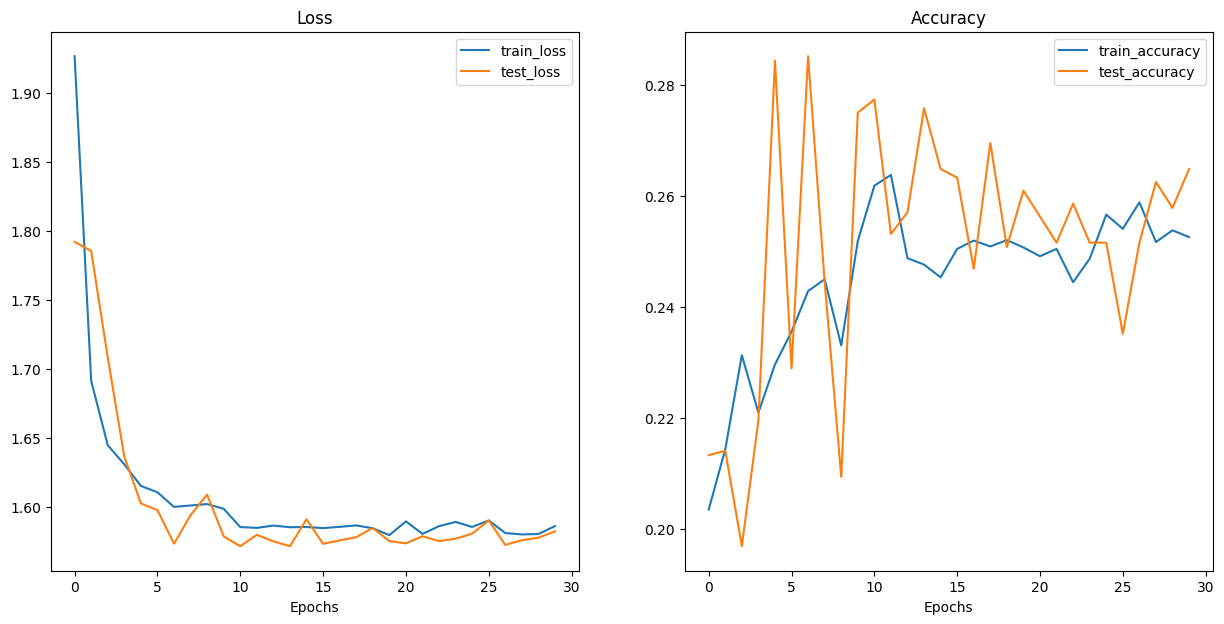

In [12]:
model_type="pretrained_vitbase"
EPOCHS = 30
LR = 0.001
model_name = f"{model_type}_lr{int(LR * 10000):04d}_{EPOCHS}epochs"
effnetb0_model_name = model_name + ".pth"
effnetb0_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb0_model_name}")
print(f"Results path: {effnetb0_results_df}")

pretrained_vitbase = create_vitbase_2(transfer_learning=False,
                                    class_names=class_names,
                                    seed=SEED).to(device)

# Train the model
if ENABLE['train_baseline']:
    # Create an example writer
    effnetb0_writer = create_writer(experiment_name="data_100_percent",
                                model_name=model_name,
                                extra=f"{EPOCHS}_epochs")
    
    # Create optimizer and loss function
    optimizer = torch.optim.Adam(params=pretrained_vitbase.parameters(),
                                lr=LR,
                                betas=(0.9, 0.999),
                                weight_decay=0.01
    )

    loss_fn = torch.nn.CrossEntropyLoss()

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitbase_results = train(model=pretrained_vitbase,
                            train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            optimizer=optimizer,
                            scheduler=None,
                            loss_fn=loss_fn,
                            epochs=EPOCHS,
                            device=device,
                            writer=None)
    
    plot_loss_curves(vitbase_results)

In [ ]:
model_type="pretrained_vitbase"
EPOCHS = 30
LR = 0.001
model_name = f"{model_type}_lr{int(LR * 10000):04d}_{EPOCHS}epochs"
effnetb0_model_name = model_name + ".pth"
effnetb0_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb0_model_name}")
print(f"Results path: {effnetb0_results_df}")

pretrained_vitbase = create_vitbase_2(transfer_learning=False,
                                    class_names=class_names,
                                    seed=SEED)

# Train the model
if ENABLE['train_baseline']:
    # Create an example writer
    effnetb0_writer = create_writer(experiment_name="data_100_percent",
                                model_name=model_name,
                                extra=f"{EPOCHS}_epochs")
    
    # Create optimizer and loss function
    optimizer = torch.optim.Adam(params=pretrained_vitbase.parameters(),
                                lr=LR,
                                betas=(0.9, 0.999),
                                #weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k
    )

    loss_fn = torch.nn.CrossEntropyLoss()

    # Train the classifier
    set_seeds(SEED)
    vitbase_results = train(model=pretrained_vitbase,
                            train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=EPOCHS,
                            device=device,
                            writer=effnetb0_writer)
    
    plot_loss_curves(vitbase_results)

Model name: pretrained_vitbase_lr0010_30epochs
Model path: pretrained_vitbase_lr0010_30epochs.pth
Results path: pretrained_vitbase_lr0010_30epochs.csv
[INFO] Created SummaryWriter, saving to: runs\2024-11-29\data_100_percent\pretrained_vitbase_lr0010_30epochs\30_epochs...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8598 | train_acc: 0.2046 | test_loss: 1.6524 | test_acc: 0.1953


KeyboardInterrupt: 

In [ ]:
# Save the EfficientNet B0 model
if ENABLE['save_baseline']:
   save_model(model=vitbase,
              target_dir=model_dir,
              model_name=effnetb0_model_name)
   df_results = pd.DataFrame(vitbase_results)
   df_results.to_csv(os.path.join(model_dir, effnetb0_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase_lr0010_30epochs.pth


## 4.3 Training Results

In [ ]:
# Instantiate the model
vitbase = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    embedding_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    embedding_dropout=0.1,
    num_classes=len(class_names)
)
# Load the trained weights
vitbase = load_model(model=vitbase,
                     model_weights_dir=model_dir,
                     model_weights_name=effnetb0_model_name)

# Load the training results
vitbase_results = pd.read_csv(os.path.join(model_dir, effnetb0_results_df))

[INFO] Loading model from: ..\models\vitbase_lr0010_30epochs.pth


In [ ]:
test_acc = vitbase_results['test_acc'].iloc[-1]
test_los = vitbase_results['test_loss'].iloc[-1]
model_size = Path(os.path.join(model_dir, effnetb0_model_name)).stat().st_size // (1024*1024)
print(f"Accuracy on the test set: {test_acc}")
print(f"Loss on the test set: {test_los}")
print(f"Model size: {model_size} MB")

Accuracy on the test set: 0.3046875
Loss on the test set: 1.5383583068847655
Model size: 327 MB
